In [449]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import gym
from gym import spaces
import random

import importlib
import util.clean_data as clean_data
import PaperEmbedding as paper_embedding
import UserModel as UserModel

importlib.reload(clean_data)
importlib.reload(PaperEmbedding)
importlib.reload(UserModel)

<module 'UserModel' from '/Users/monika/fair-bibliography-discovery-reinforcement-learning/src/UserModel.py'>

In [162]:
full_df = pd.read_csv("../data/scientometrics-and-bibliometrics-research.csv", low_memory=False)
df = clean_data.select_relevant_features(full_df)
df['topics.display_name'] = df['topics.display_name'].apply(lambda x: clean_data.pad_topic_list(x, max_len=3, pad_token="<PAD>"))
df['topics.score'] = df['topics.score'].apply(lambda x: clean_data.pad_topic_list(x, max_len=3, pad_token=0.0))
df = clean_data.normalize_numerical_features(df)

In [163]:
df

,title,publication_year,cited_by_count,topics.display_name,topics.score,publication_year_norm,cited_by_count_norm
0,How to conduct a bibliometric analysis: An ove...,2021,6635,"[scientometrics and bibliometrics research, <P...","[0.9736, 0.0, 0.0]",0.996341,1.000000
1,Analyzing the past to prepare for the future: ...,2002,6002,"[scientometrics and bibliometrics research, De...","[0.8112, 0.8084, 0.7988]",0.978037,0.987637
2,Co‐citation in the scientific literature: A ne...,1973,4591,"[scientometrics and bibliometrics research, <P...","[0.9994, 0.0, 0.0]",0.946613,0.954593
3,"Comparison of PubMed, Scopus, Web of Science, ...",2007,3769,"[scientometrics and bibliometrics research, Bi...","[0.9943, 0.9924, 0.9793]",0.983010,0.930270
4,The journal coverage of Web of Science and Sco...,2015,3167,"[scientometrics and bibliometrics research, Ac...","[0.9994, 0.9448, 0.9224]",0.990731,0.908817
...,...,...,...,...,...,...,...
50195,Issue Publication Information,2018,0,"[scientometrics and bibliometrics research, <P...","[0.5676, 0.0, 0.0]",0.993555,0.000000
50196,W. A. TAYLOR and CO.,1961,0,"[scientometrics and bibliometrics research, Ir...","[0.8668, 0.8155, 0.7664]",0.932099,0.000000
50197,VARIAN associates,1962,0,"[scientometrics and bibliometrics research, In...","[0.2804, 0.2517, 0.0]",0.933348,0.000000
50198,scientific products,1963,0,"[scientometrics and bibliometrics research, <P...","[0.315, 0.0, 0.0]",0.934589,0.000000


In [750]:
class PaperDiscoveryEnv(gym.Env):
    def __init__(self, df, num_recommendations=10):
        super(PaperDiscoveryEnv, self).__init__()
        
        # Data
        self.df = df
        topic_to_index = {topic: idx for idx, topic in enumerate(sorted(set(self.df['topics.display_name'].explode().unique())))}
        self.df['topics.indices'] = self.df['topics.display_name'].apply(lambda topics: clean_data.generate_topic_indices(topics, topic_to_index))
        self.df

        num_topics = len( topic_to_index)
        embedding_dim = 64                 # Each topic is represented by a 64-dimensional vector.
        topic_output_dim = 128             # Intermediate representation dimension for the topic branch.
        final_dim = 256                    # Final paper embedding dimension.
        pad_idx = topic_to_index["<PAD>"]
        numeric_feature_dim = 2            # We use two numeric features: publication_year and cited_by_count

        topic_tensor = torch.tensor(df['topics.indices'].tolist(), dtype=torch.long)
        scores_tensor = torch.tensor(df['topics.score'].tolist(), dtype=torch.float)
        publication_year = torch.tensor(np.array(df['publication_year'].tolist(), dtype=np.float32)).unsqueeze(1)
        cited_by_count = torch.tensor(np.array(df['cited_by_count'].tolist(), dtype=np.float32)).unsqueeze(1)
        numeric_features = torch.cat([publication_year, cited_by_count], dim=1)

        embedding = paper_embedding.PaperEmbeddingModule(num_topics, embedding_dim, topic_output_dim, pad_idx,
                             numeric_feature_dim, final_dim)
        self.paper_pool = embedding(topic_tensor, scores_tensor, numeric_features)
        self.num_recommendations = num_recommendations

        # User
        self.user = UserModel.UserModel()

        # State Space (e.g., paper features: relevance, reputability, novelty)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(256,), dtype=np.float32)

        # Action Space (10 papers at a time)
        self.action_space = spaces.MultiDiscrete([len(self.df)] * 10)

        # Track seen papers to avoid recommending duplicates
        self.recommended_papers = set()
        self.clicked_papers = set()
        self.clicked_scores = list()

    def reset(self):
        """Reset environment at the start of a new episode."""
        self.recommended_papers = set()
        self.clicked_papers = set()
        self.clicked_scores = list()
        return self.get_state()

    def get_state(self):
        clicked_embeddings = self.paper_pool[list(self.clicked_papers)]
        clicked_scores_tensor = torch.tensor(list(self.clicked_scores), dtype=torch.float)
        weighted_average_clicked_score = (clicked_embeddings * clicked_scores_tensor.unsqueeze(1)).sum(dim=0) / (clicked_scores_tensor.sum() + 1e-8)
        return weighted_average_clicked_score

    def step(self, action):
        """
        Simulate user engagement and return reward.
        
        action: A list of recommended paper's indexes.
        """

        # print(f"Choice: {action}")

        if isinstance(action, torch.Tensor):
            action = action.cpu().tolist()

        chosen_dict = self.user.choose(self.df.iloc[action])
        reward = len(chosen_dict) - 1 * (self.num_recommendations - len(chosen_dict))

        for key, value in list(chosen_dict.items()):
            if key not in self.recommended_papers:
                self.clicked_papers.add(key)
                self.clicked_scores.append(value)

        # Track papers that have already been shown to the user
        self.recommended_papers.update(action)
        # self.clicked_papers.update(chosen_idx)
        # self.clicked_scores.extend(chosen_scores)

        # Generate next state: Random unseen paper

        next_state = self.get_state()

        # Done condition: End episode after 10 recommendations
        done = len(self.clicked_papers) >= self.num_recommendations

        return next_state, reward, done, False, {}

In [751]:
# Testing environment with random actions
env = PaperDiscoveryEnv(df)

num_episodes = 1000
total_reward = 0

for i in range(num_episodes):
    state = env.reset()
    terminated = False

    all_actions = set(range(len(env.df)))
    used_actions = set()

    while not terminated:
        available_actions = list(all_actions - used_actions)
        actions = np.random.choice(available_actions, size=10, replace=False)
        state, reward, terminated, _, _ = env.step(actions)
        total_reward += reward  # Track total reward

# Compute and print the average reward
average_reward = total_reward / num_episodes
print(f"Average Reward over {num_episodes} episodes: {average_reward}")

RuntimeError: The size of tensor a (10) must match the size of tensor b (11) at non-singleton dimension 0

In [755]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [756]:
from collections import namedtuple, deque
import torch.nn as nn

Transition = namedtuple("Transition", ["state", "action", "next_state", "reward"])

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):

    def __init__(self, n_observations, n_action, n_neurons, candidate_pool_size):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, n_neurons)
        self.layer2 = nn.Linear(n_neurons, n_neurons)
        self.layer3 = nn.Linear(n_neurons, n_action * candidate_pool_size)
        self.n_action = n_action
        self.candidate_pool_size = candidate_pool_size

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        # Reshape the output into [batch_size, n_action, candidate_pool_size]
        return x.view(-1, self.n_action, self.candidate_pool_size)

In [773]:
import torch.optim as optim
import math
import torch.nn.functional as F

class Agent:
    def __init__(
        self,
        env,
        batch_size=128,
        gamma=0.8,
        eps_start=0.9,
        eps_end=0.05,
        eps_decay=500,
        lr=0.001,
        n_neurons=128,
    ):

        self.env = env
        self.batch_size = batch_size
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.lr = lr
        self.n_neurons = n_neurons

        self.n_observations = self.env.observation_space.shape[0]
        self.n_actions = env.action_space.shape[0]

        state = env.reset()

        self.policy_net = DQN(self.n_observations, self.n_actions, self.n_neurons, len(self.env.df)).to(device)

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr, amsgrad=True)
        self.memory = ReplayMemory(10000)

        self.steps_done = 0

    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
            math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1

        # Retrieve candidate pool size and slate size.
        candidate_pool_size = len(self.env.df)  # total number of candidate papers
        slate_size = self.env.action_space.shape[0]  # number of recommendations to output (e.g., 10)
        # print(f"Threshold = {eps_threshold}")
        
        if sample > eps_threshold:
            # print("Recommend from Q-Learning")
            with torch.no_grad():
                q_values = self.policy_net(state)
                mask = torch.zeros(1, candidate_pool_size, device=device, dtype=torch.bool)
                if self.env.recommended_papers:
                    invalid_indices = list(self.env.recommended_papers)
                    mask[0, invalid_indices] = True
                mask = mask.unsqueeze(1).expand(1, slate_size, candidate_pool_size)
                q_values = q_values.masked_fill(mask, float('-inf'))
                actions = torch.argmax(q_values, dim=2)
                return actions.squeeze(0).tolist()
        else:
            # print("Recommend at random")
            valid_candidates = list(set(range(candidate_pool_size)) - self.env.recommended_papers)
            # If there are fewer valid candidates than needed, fallback to the full candidate set.
            if len(valid_candidates) < slate_size:
                valid_candidates = list(range(candidate_pool_size))
            random_action_list = random.sample(valid_candidates, slate_size)
            # print(random_action_list)
            # random_action = torch.tensor([random_action_list], device=device, dtype=torch.long)
            return random_action_list

    def train(self, num_episodes=1000):
        rewards = []
        for i_episode in range(num_episodes):
            # if i_episode % 1000 == 0:
            #     print(f"Episode {i_episode}/{num_episodes}")
            terminated = False
            state = self.env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            episode_reward = 0

            while not terminated:
                action = self.select_action(state)
                observation, reward, terminated, _, _ = self.env.step(action)
                # reward = torch.tensor([reward], device=device)
                episode_reward += reward

                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

                self.memory.push(state, action, next_state, reward)

                state = next_state

            # print(f"EPISODE {i_episode} - reward: {episode_reward}")
            rewards.append(episode_reward)
            self.optimize_model()

        return rewards

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.stack([torch.tensor(x, dtype=torch.long, device=device) for x in batch.action])
        reward_batch = torch.tensor(batch.reward, dtype=torch.float32, device=device).view(-1, 1)
        # reward_batch = torch.tensor(batch.reward, dtype=torch.float32, device=device)

        q_values = self.policy_net(state_batch)
        action_batch_exp = action_batch.unsqueeze(2)
        chosen_q = q_values.gather(2, action_batch_exp).squeeze(2)
        state_action_values = chosen_q.sum(dim=1, keepdim=True)
        next_state_values = torch.zeros(self.batch_size, device=device)

        # print(f"q-values: {q_values.shape}")
        # print(f"action_batch_exp: {action_batch_exp.shape}")
        # print(f"chosen_q: {chosen_q}")
        # print(f"state-action values: {state_action_values.shape}")

        # print(f"non final next state: {non_final_next_states.shape}")

        if non_final_next_states.shape[0] > 0:
            next_q_values = self.policy_net(non_final_next_states)
            next_max_per_slot = next_q_values.max(dim=2)[0]
            next_state_values[non_final_mask] = next_max_per_slot.sum(dim=1)

        #     print(f"next_q_values: {next_q_values.shape}")
        #     print(f"next_max_per_slot: {next_max_per_slot.shape}")
        
        # print(f"next_state_values: {next_state_values.unsqueeze(1)}")

        expected_state_action_values = reward_batch + (self.gamma * next_state_values.unsqueeze(1))

        criterion = nn.SmoothL1Loss()
        # print(state_action_values.shape)
        # print(expected_state_action_values.shape)
        loss = criterion(state_action_values, expected_state_action_values)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

In [768]:
def plot_rewards(rewards, num_episodes):
    reward_array = np.array(rewards)
    window_size = 500

    # Compute moving average using np.convolve
    moving_avg = np.convolve(reward_array, np.ones(window_size) / window_size, mode='valid')

    # Plot moving average
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(moving_avg)), moving_avg, label=f"Moving Average ({window_size} episodes)", color='blue')
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.title(f"Moving Average of Rewards Over {num_episodes} Episodes")
    plt.ylim(-1, max(moving_avg) + 0.5)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [758]:
env = PaperDiscoveryEnv(df)
agent = Agent(env)
rewards = agent.train(num_episodes=10000)

Episode 0/10000


/var/folders/7y/58r1nbq91psb3zbw1k0f7bzc0000gn/T/ipykernel_26536/2113365289.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
/var/folders/7y/58r1nbq91psb3zbw1k0f7bzc0000gn/T/ipykernel_26536/2113365289.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


Episode 1000/10000
Episode 2000/10000
Episode 3000/10000
Episode 4000/10000
Episode 5000/10000
Episode 6000/10000
Episode 7000/10000
Episode 8000/10000
Episode 9000/10000


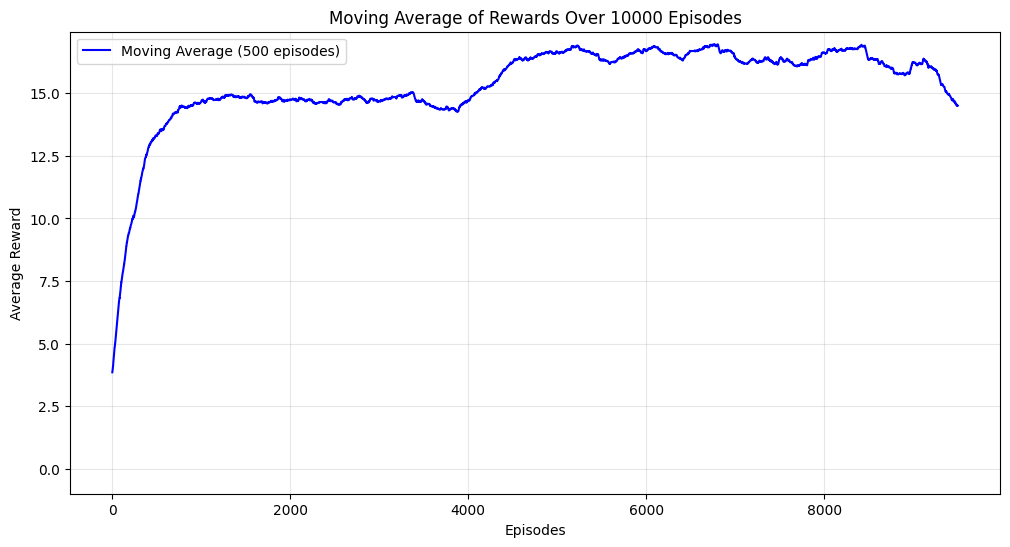

In [769]:
plot_rewards(rewards, num_episodes=10000)

In [775]:
from itertools import product

hyperparameters = {
    'lr': [0.001, 0.0005],
    'eps_decay': [250, 500, 750],
    'batch_size': [128, 256],
    'n_neurons': [128, 256],
    'gamma': [0.8, 0.9, 1]
}
num_episodes = 8000

best_dqn_reward = [float('-inf')]
best_dqn_params = None
dqn_rewards = []

for lr, eps_decay, batch_size, n_neurons, gamma in product(
    hyperparameters['lr'],
    hyperparameters['eps_decay'],
    hyperparameters['batch_size'],
    hyperparameters['n_neurons'],
    hyperparameters['gamma']):

    try:
        env = PaperDiscoveryEnv(df)
        agent = Agent(env, lr=lr, eps_decay=eps_decay, batch_size=batch_size, n_neurons=n_neurons, gamma=gamma)
        rewards = agent.train(num_episodes=num_episodes)
        dqn_rewards.append(rewards)
        sum_dqn_rewards = sum(rewards)

        print(f"{(lr, eps_decay, batch_size, n_neurons, gamma)} - avg. reward = {sum_dqn_rewards / num_episodes}")


        if sum_dqn_rewards > sum(best_dqn_reward):
            best_dqn_reward = rewards
            best_dqn_params = {'lr': lr, 'eps_decay': eps_decay, 'batch_size': batch_size, 'n_neurons': n_neurons, 'gamma': gamma}
            torch.save(agent.policy_net.state_dict(), "best_dqn.pth")
    except Exception as e:
        continue

print(f"Best hyperparameters: {best_dqn_params} with average reward: {best_dqn_reward}")

/var/folders/7y/58r1nbq91psb3zbw1k0f7bzc0000gn/T/ipykernel_26536/3813415055.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
/var/folders/7y/58r1nbq91psb3zbw1k0f7bzc0000gn/T/ipykernel_26536/3813415055.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


(0.001, 250, 128, 128, 0.8) - avg. reward = 16.00875
(0.001, 250, 128, 128, 0.9) - avg. reward = 15.59625
(0.001, 250, 128, 128, 1) - avg. reward = 15.3305
(0.001, 250, 128, 256, 0.8) - avg. reward = 14.75075
(0.001, 250, 128, 256, 0.9) - avg. reward = 15.051
(0.001, 250, 128, 256, 1) - avg. reward = 13.82975
(0.001, 250, 256, 128, 0.8) - avg. reward = 15.22125
(0.001, 250, 256, 128, 0.9) - avg. reward = 15.52275
(0.001, 250, 256, 128, 1) - avg. reward = 14.55675
(0.001, 250, 256, 256, 0.8) - avg. reward = 15.25275
(0.001, 250, 256, 256, 0.9) - avg. reward = 14.9805
(0.001, 250, 256, 256, 1) - avg. reward = 14.44325
(0.001, 500, 128, 128, 0.8) - avg. reward = 15.42875
(0.001, 500, 128, 128, 0.9) - avg. reward = 15.292
(0.001, 500, 128, 128, 1) - avg. reward = 15.052
(0.001, 500, 128, 256, 0.8) - avg. reward = 14.093
(0.001, 500, 128, 256, 0.9) - avg. reward = 15.80525
(0.001, 500, 128, 256, 1) - avg. reward = 14.49325
(0.001, 500, 256, 128, 0.8) - avg. reward = 14.8875
(0.001, 500, 256